# IMA205 Challenge

Louis Martinez

In [92]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io, color
from skimage.measure import label
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.feature import peak_local_max


import os

## Loading data

In [93]:
def load_nifti(path):
    """Function to load a nifti file"""
    return nib.load(path).get_fdata()

def load_mris(dir):
    """Function to load all the mris in a directory"""
    mris = []
    for sample_dir in os.listdir(dir):
        mri_dir = os.path.join(dir, sample_dir)
        sample_mris = []
        for mri in os.listdir(mri_dir):
            # Load mri
            mri_data = load_nifti(os.path.join(mri_dir,mri))

            sample_mris.append(mri_data)

        mris.append(sample_mris)

    return np.array(mris, dtype=object)

def overlay_mask(mri, seg):
    """Function to overlay a mask on a mri"""
    gray_img = mri/255
    mask_img = seg
    
    labels = label(mask_img)
    overlayed_img = color.label2rgb(labels, image=gray_img, colors=['red', 'green', 'blue'], alpha=0.5)
    
    return overlayed_img

def plot_slices(slices, title, mask=False):
    """Function to plot slices of a mri or a mask"""
    n_slices = 10
    if np.shape(slices)[0] != 10:
        slices=[np.split(slices, 10, axis=2)[i].reshape((216,256)) for i in range(10)]
    fig, axes = plt.subplots(2, 5, figsize=(25, 6))
    ax=axes.ravel()
    fig.suptitle(title, fontsize=16)
    for i in range(n_slices):
        if mask: ax[i].imshow(slices[i]) 
        else: 
            pcm = ax[i].pcolormesh(slices[i])
            fig.colorbar(pcm, ax=ax[i])
            
        
        ax[i].set_title(f'Slice {i+1}')
        ax[i].axis('off')

def normalize(mri):
    """Function to normalize a mri"""
    return (mri - np.min(mri)) / (np.max(mri) - np.min(mri))

In [94]:
# LOAD CSV FILES

train_csv='metaDataTrain.csv'
test_csv='metaDataTest.csv'

df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)

X_train=df_train[['Height','Weight']].to_numpy()
y_train=df_train[['Category']].to_numpy().ravel()
X_test=df_test[['Height','Weight']].to_numpy()

X_cat = np.array([X_train[y_train == i] for i in range(y_train.max() + 1)]) # split by category
print(f'Shape of X_cat : {X_cat.shape}')

Shape of X_cat : (5, 20, 2)


We notice that categories are well balanced, which is good for model training

In [95]:
# LOAD MRI DATA
train_dir = 'Train'
test_dir = 'Test'

# Contain all 4 mris of each patient
mri_train = load_mris(train_dir)
mri_test = load_mris(test_dir)

In [96]:
# Shape of an mri (10 slices, 256x256 images)
mri_train[0][0].shape

(216, 256, 10)

We plot height and weight for each category 

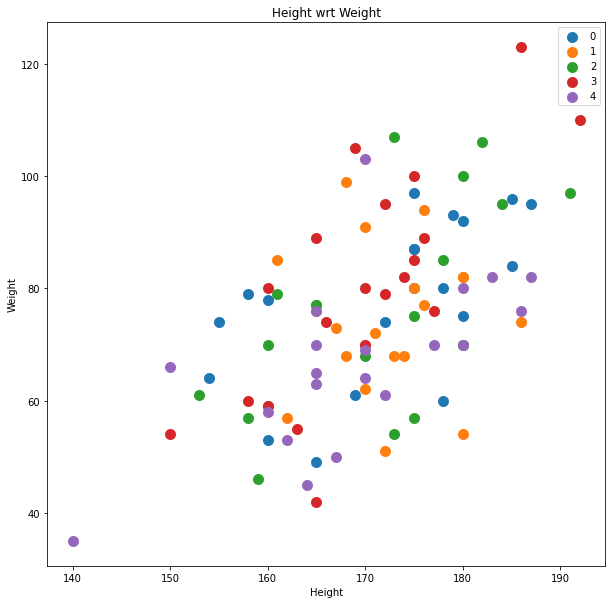

In [97]:
plt.figure(figsize=(10,10))
for i in range(len(X_cat)):
    plt.scatter(X_cat[i][:,0], X_cat[i][:,1], label=str(i), linewidths=5)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.title('Height wrt Weight')
plt.legend()
plt.show()

There seem to be no easy way to separate data into distinct categories only according to there distribution.<br>
It justifies the fact that we need to extract features from heart MRIs to seperate categories.

Plot MRI's

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


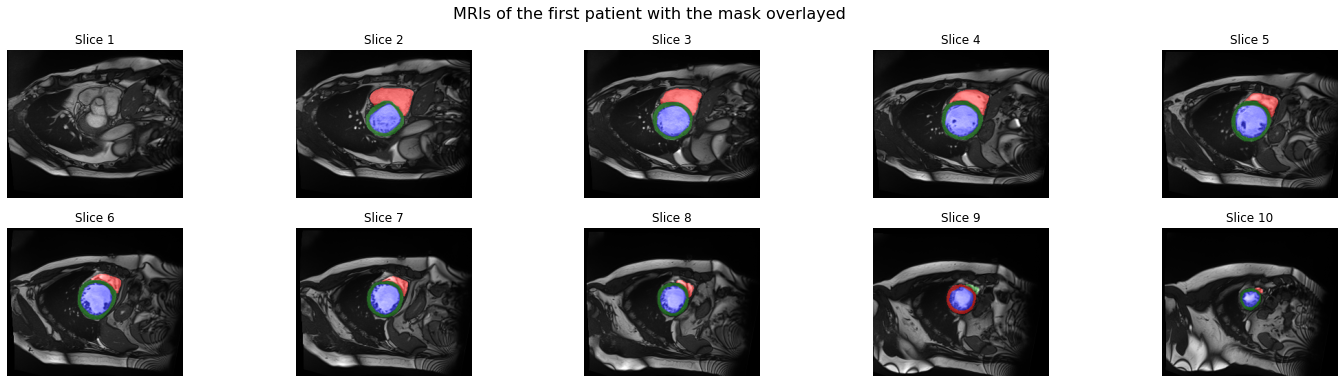

In [98]:
patient_idx=0
sample_idx = 0
seg_idx = 1

mri_ex=mri_train[patient_idx] # mris of the first patient
mri_ed=mri_ex[sample_idx].transpose(2,0,1) # mri of the first patient, first mri (edema)
mri_seg=mri_ex[seg_idx].transpose(2,0,1) # segmentation of the first mri, second mri (seg)

mri_ed_n =np.array([normalize(mri_ed[i]) for i in range(10)])

# masked_mris=[overlay_mask(mri_ex[sample_idx][:,:,i], mri_ex[seg_idx][:,:,i]) for i in range(10)]
masked_mris=[overlay_mask(mri_ed[i], mri_seg[i]) for i in range(10)]
plot_slices(masked_mris, 'MRIs of the first patient with the mask overlayed', mask=True)


## Left ventricle segmentation

We first elaborate the pipeline on mris from the training set in order to compare the results with the original segmentation.<br>
Then we apply it to the test set

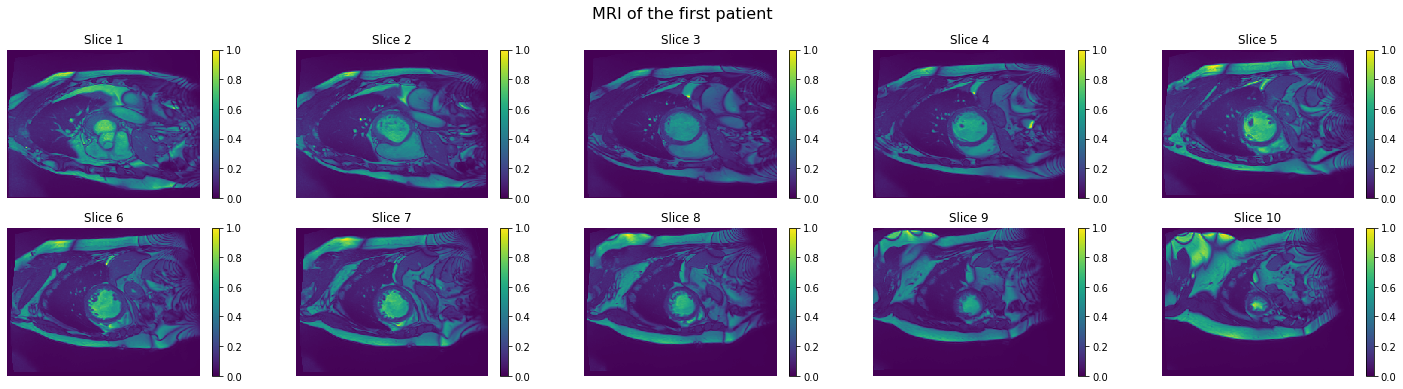

In [99]:
im=np.copy(mri_train[patient_idx][sample_idx].transpose(2,0,1))
im=np.array([normalize(im[i]) for i in range(10)])
im_seg=np.copy(mri_train[patient_idx][seg_idx].transpose(2,0,1))
plot_slices(im, 'MRI of the first patient')

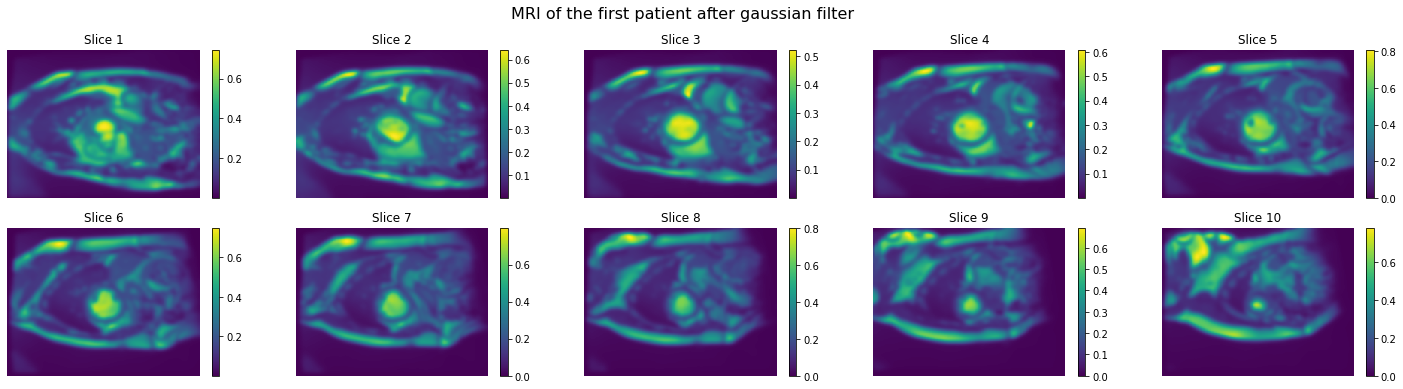

In [100]:
from skimage.filters import gaussian

for i in range(10):
    im[i]=gaussian(im[i], sigma=3)

plot_slices(im, 'MRI of the first patient after gaussian filter')

On the colormesh, we notive that the left ventricle is bright and surrounded by a darker area.<br>
So we isolate it using a threshold :

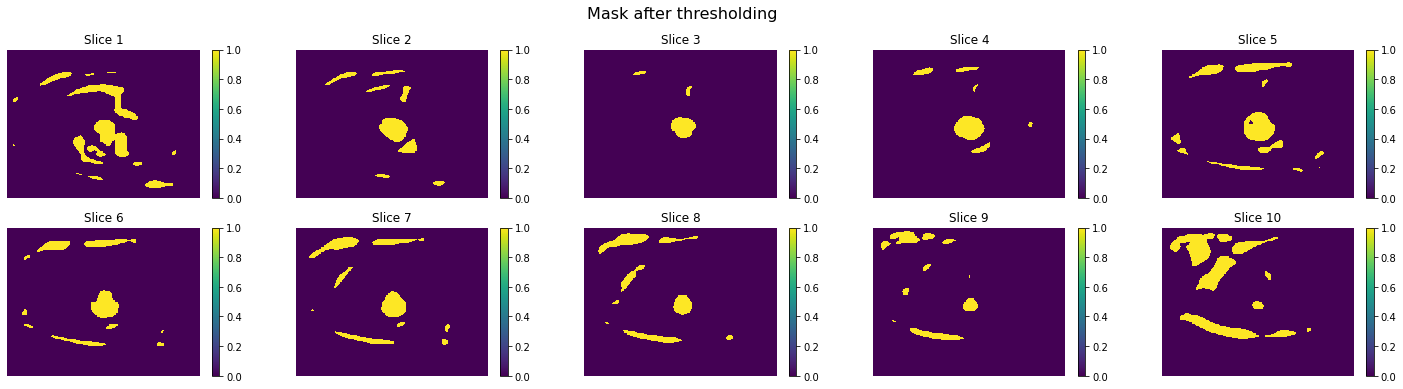

In [108]:
mask=im>0.45
plot_slices(mask, 'Mask after thresholding')

Now we apply morphological transformations to clean the area of interest. 

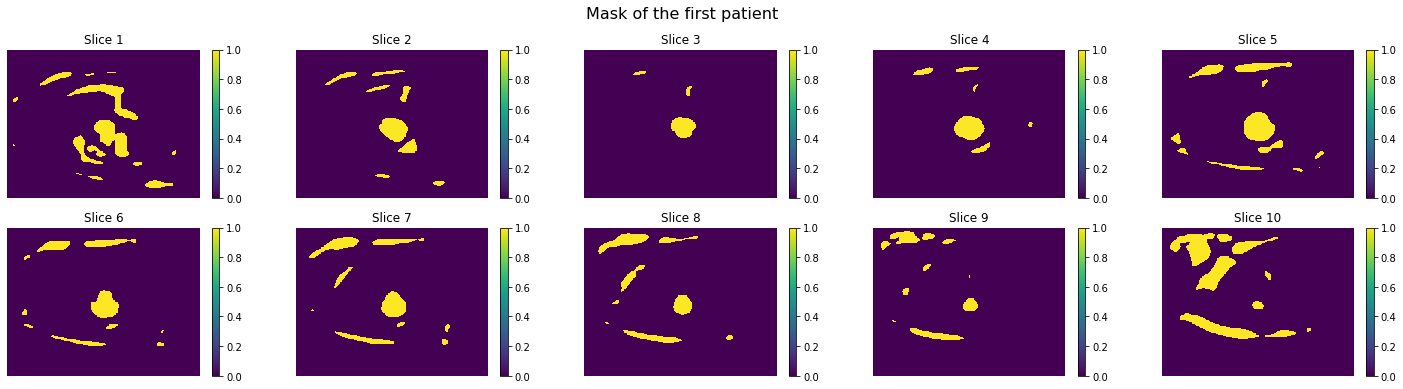

In [109]:
from skimage.morphology import area_closing, dilation

mask_closed=np.vectorize(area_closing, signature='(n,m)->(n,m)')(mask.astype(int))
plot_slices(mask_closed, 'Mask of the first patient')

Now we label each area in order to uniquely identify them on each image, and then select the one corresponding to the left ventricle

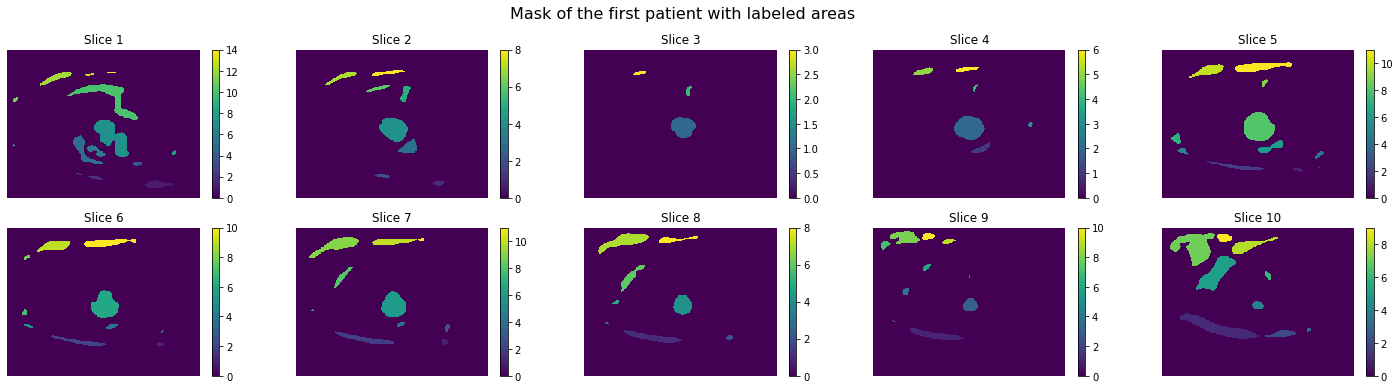

In [110]:
from skimage.measure import label, regionprops

mask_labeled=np.vectorize(label, signature='(n,m)->(n,m)')(mask_closed)
plot_slices(mask_labeled, 'Mask of the first patient with labeled areas')

We can notice that in all slices, the left ventricle is one of the most convex parts, and is located in the center of the mri.<br>
So we use these two properties to select this part.

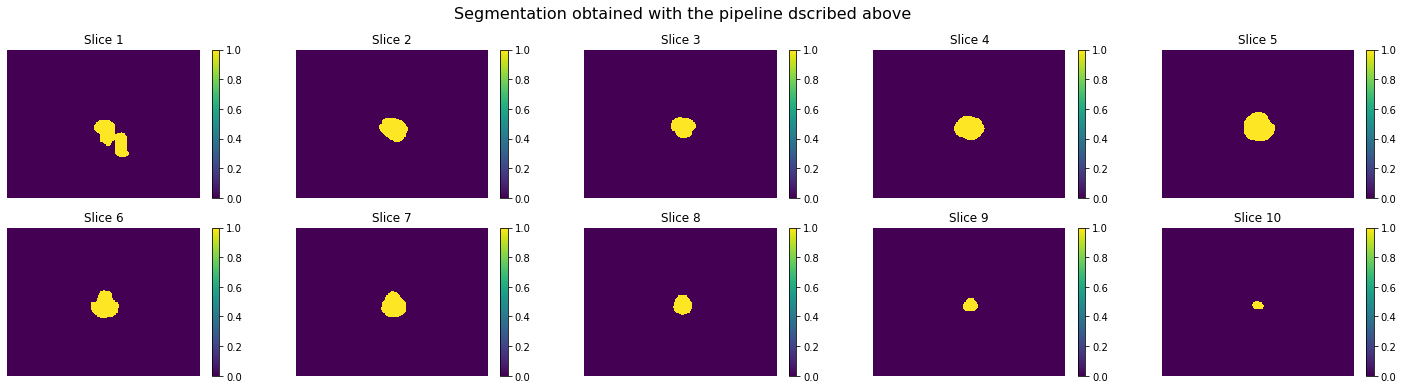

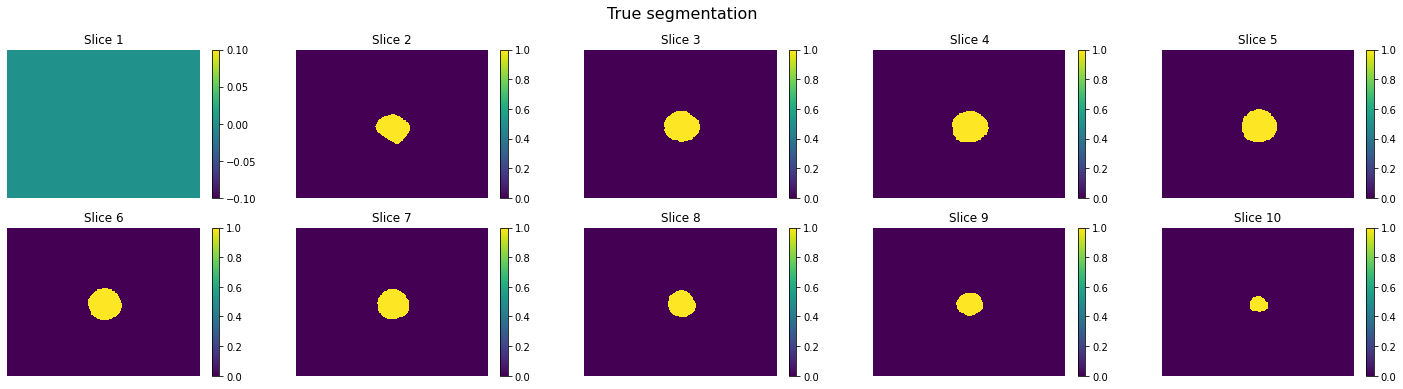

In [111]:
def extract_ventricle(slc):
    r,c=slc.shape
    img_center=np.array([r,c])//2
    props=np.array(regionprops(slc))

    # Compute distances to center
    distances=[np.linalg.norm(img_center-prop.centroid) for prop in props]
    new_idx=np.argsort(distances)[0] # keep only the closest to the center

    # Compute convexity
    # convexity=[prop.area/prop.convex_area for prop in props]
    # idxs=np.argsort(convexity)[::-1] # from largest to smallest
    # idxs=idxs[:6] # keep only the 5 most convex areas

    new_slc=np.zeros_like(slc)
    new_slc[tuple(props[new_idx].coords.T)]+=1
    return new_slc

mask_ventricle=np.vectorize(extract_ventricle, signature='(n,m)->(n,m)')(mask_labeled)

plot_slices(mask_ventricle, 'Segmentation obtained with the pipeline dscribed above')
plot_slices(im_seg == 3, 'True segmentation')

## Features extraction